**<span style="color:#0638b2; font-size:32px">
Phase II - Model Fine Tuning and Saving w/ Combined Dataset
</span>** <br>

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras import layers, regularizers   ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
## Import EFB3 Model Weights
from tensorflow.keras.applications import EfficientNetB3

import pathlib
import zipfile

In [4]:
os.getcwd()

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

**<span style="color:#180842; font-size:26px">
Train/Validation Data Pull
</span>** <br>

In [5]:
# Specify the path to the zip file
# dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1" ## CAS only data.
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/sy3duklriddl3fo668as8/ls_model_data_six_combined_v2.zip?rlkey=chgywsbsn3ny0m2vrllll8icx&dl=0?raw=1" 

In [6]:
data_dir = tf.keras.utils.get_file('ls_model_data_six_combined_v2.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7132


In [8]:
# Drill into each subdirectory and list counts per folder
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3115 .jpg images

Contents of folder 'non_landslide':
non_landslide: 4017 .jpg images


**<span style="color:#180842; font-size:26px">
Test Data Pull
</span>** <br>

In [9]:
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
# test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1"
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/kl3e9wxoibqu0ldogwxg0/test_google_images_landslides_five.zip?rlkey=zuhh6xvjy3oi9wuroy4ogtdi3&dl=0?raw=1"
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/a8evtoop10e9cadnxorqw/google_earth_unique_test.zip?rlkey=g463zbw32hn5ez80wb1qogw4g&dl=0?raw=1"

In [10]:
data_dir_test = tf.keras.utils.get_file('google_earth_unique_test.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [11]:
## Review folders in incoming data / classes
folders_test = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_test:
    print(folder.name)

Folders in the test directory:
landslides
non-landslides


In [12]:
# Drill into each subdirectory and list counts per folder
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslides':
landslides: 31 .jpg images

Contents of folder 'non-landslides':
non-landslides: 31 .jpg images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [13]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [14]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7132 files belonging to 2 classes.
Using 6063 files for training.


2024-12-08 23:17:04.826126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43483 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:63:00.0, compute capability: 8.6


In [15]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7132 files belonging to 2 classes.
Using 1069 files for validation.


In [16]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset.unbatch())
valid_count = sum(1 for _ in valid_dataset.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset, train_class_counts)
count_classes(valid_dataset, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-12-08 23:17:09.381048: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 23:17:09.816953: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 6063
Validation set size: 1069

Class distribution in Training set:
  Class 0: 2665 samples
  Class 1: 3398 samples

Class distribution in Validation set:
  Class 0: 450 samples
  Class 1: 619 samples


2024-12-08 23:17:12.350601: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Buffering/Shuffle

In [17]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(3200).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

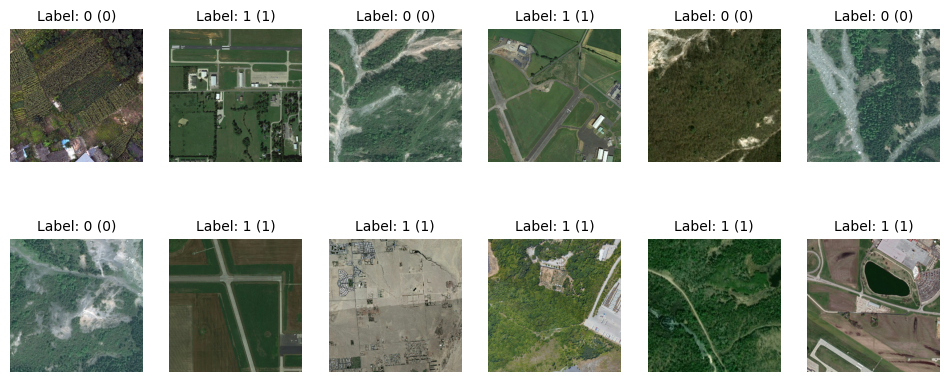

In [18]:
## Checking Images and Labels:
plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(12):  # Display first 6 samples
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

**<span style="color:#180842; font-size:26px">
Set Test Data
</span>** <br>

In [19]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) #/ 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/waa4bq/.keras/datasets/google_earth_unique_test_extracted')

In [20]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=614,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 62 files belonging to 2 classes.


In [21]:
## Review class names based on dataset. 
class_names = test_dataset.class_names
print(class_names)

['landslides', 'non-landslides']


In [22]:
# # Shuffle the dataset while keeping labels aligned
# test_dataset = test_dataset.shuffle(buffer_size=100, seed=614, reshuffle_each_iteration=False)

# # Optionally, prefetch for better performance
# test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

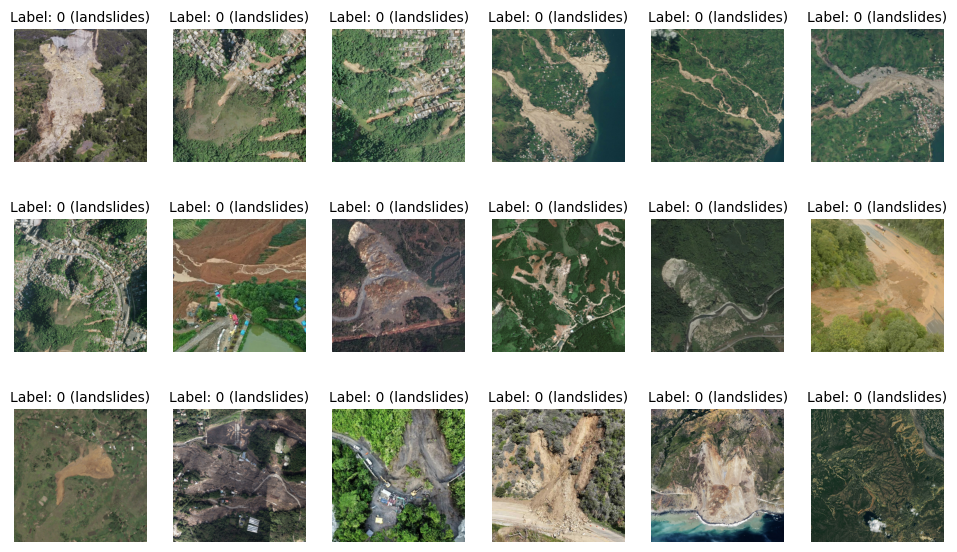

In [23]:
## Checking the Labels. 
plt.figure(figsize=(12, 7))
for images, labels in test_dataset.take(1):  # Take one batch
    for i in range(18):  # Display first 6 samples
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [24]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.1375234521575985, 1: 0.8921424367274867}


<hr style="border:8px solid #301b66">

### **Helper Functions**

In [46]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']
    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(6, 10), dpi=150)
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('EfficientNetB3 Training and Validation Accuracy')
    plt.xlabel('Epochs')  # Add x-axis label

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('EfficientNetB3 Training and Validation Loss')
    plt.xlabel('Epochs')  # Add x-axis label
    # Adjust layout to add space between graphs
    plt.subplots_adjust(hspace=0.5)  # Adjusts vertical space (0.5 can be adjusted as needed)
    
    plt.show()

Saturation
- The saturation factor is sampled randomly from a uniform distribution in the range [lower, upper].
- A saturation factor of 1.0 means no change in saturation.
- A saturation factor below 1.0 decreases the saturation (the image will appear less vibrant or more grayscale).
- A saturation factor above 1.0 increases the saturation (the image will appear more vibrant).

#### **Augmentation**

In [27]:
### Data Augmentation Helper
# data_augmentation = keras.Sequential(
#   [
#     keras.layers.RandomRotation(factor=0.10),
#     keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     keras.layers.RandomFlip("horizontal"),
#     keras.layers.RandomContrast(factor=0.5),
#     keras.layers.RandomBrightness(factor=.6),
      
#     # layers.RandomSaturation(.7, seed=516) ## Error
#     keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
#   ]
# )

data_augmentation = keras.Sequential(
  [
    # keras.layers.Input((350, 350, 3)),
    keras.layers.RandomRotation(factor=0.40),
    keras.layers.RandomTranslation(height_factor=0.4, width_factor=0.4, fill_mode="reflect"),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    # keras.layers.RandomCrop(300, 300),
    keras.layers.RandomContrast(factor=0.7), ## Values closer to 0 = minimal adjustment, higher to 1.0 allow larger contrast variations.
    keras.layers.RandomBrightness(factor=.7),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.7, upper=1.3))
  ]
)

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Model Design w/ Transfer Learning
</span>** <br>


Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Setting up EfficientNet**
- Note - using B3 as this is set up for 300x300 images. 

In [28]:
## Calc. the number of classes. 
land_class_num = len(folders)
print(f'Number of classes detected: {land_class_num}') ## Check class number AND use as argument below.

Number of classes detected: 2


In [29]:
# Setting up parameters for model. 
IMG_SIZE = 300
learn_rate_land = .000  ## For optimizer. 1e-4

<hr style="border:10px solid #301b66">

## **Model**

### **Define Model Design**

In [31]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes, learning_r):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
       
    ### Adding Augmentation
    augmented_inputs = data_augmentation(inputs)  ## Added Line
    
    ### Add a rescaling layer to normalize pixel values to range [0, 1] !! EFNet Needs images 0 to 255, This caused a large decrease in performance...
    # normalized_inputs = Rescaling(scale=1.0 / 255)(augmented_inputs)
    
    model = EfficientNetB3(include_top=False, input_tensor=augmented_inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.25
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learning_r)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

### **Build Model**

In [100]:
### Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num, learning_r=learn_rate_land)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

In [90]:
### Review of the model structure:   Confirm that no layers are open after set.
# landslide_model_ENB3.summary(show_trainable=True)

### **Fit**

In [91]:
epochs = 15  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)

Epoch 1/15


2024-12-08 21:34:02.993452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNet_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.7673 - loss: 0.5498 - val_accuracy: 0.9055 - val_loss: 0.2766
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.8777 - loss: 0.2883 - val_accuracy: 0.9298 - val_loss: 0.2018
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.8963 - loss: 0.2591 - val_accuracy: 0.9448 - val_loss: 0.1662
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.8987 - loss: 0.2508 - val_accuracy: 0.9401 - val_loss: 0.1713
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.9030 - loss: 0.2448 - val_accuracy: 0.9495 - val_loss: 0.1466
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.9162 - loss: 0.2222 - val_accuracy: 0.9523 - val_loss: 0.1329
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.9171 - loss: 0.2173 - val_accuracy: 0.9439 - val_loss: 0.1283
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.9026 - loss: 0.2269 - val_accuracy: 0.945

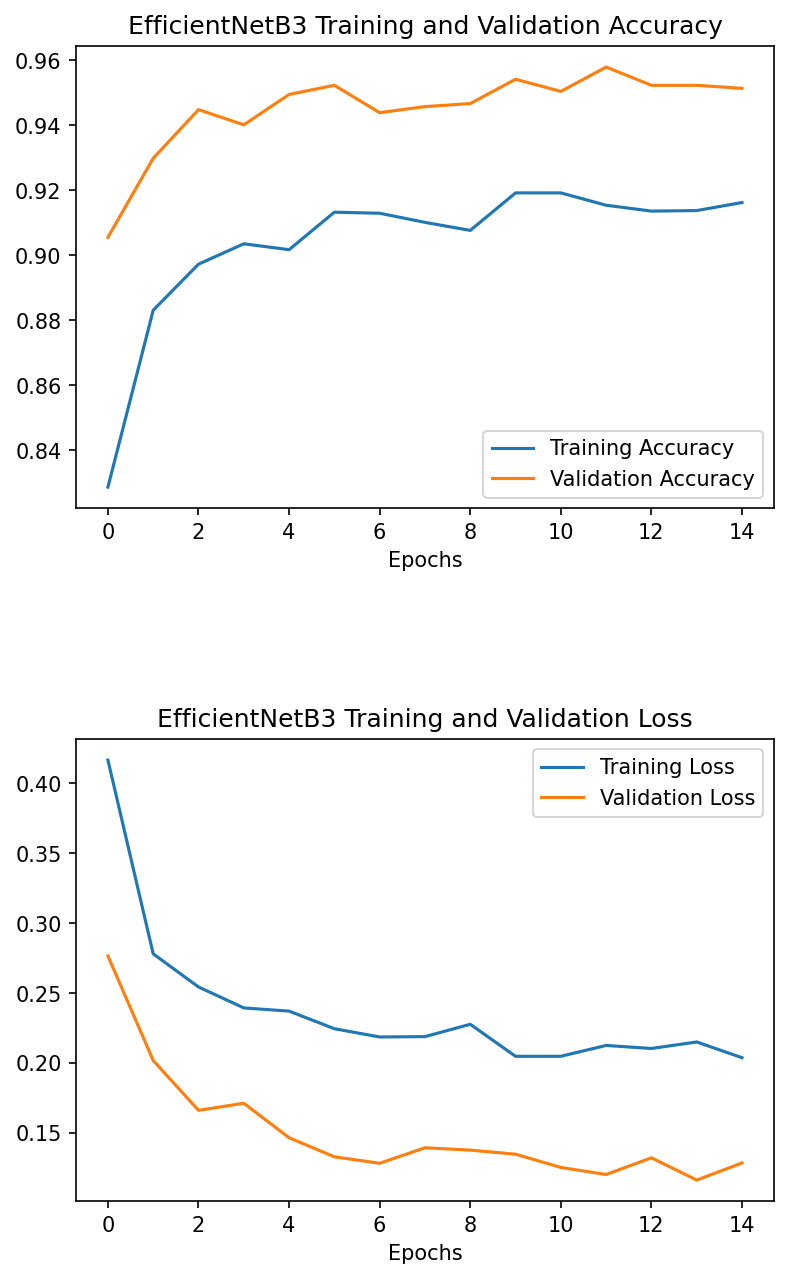

In [92]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

### **Testing**

In [93]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7742 - loss: 0.5004
test loss, test acc: [0.5004096031188965, 0.774193525314331]


In [94]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


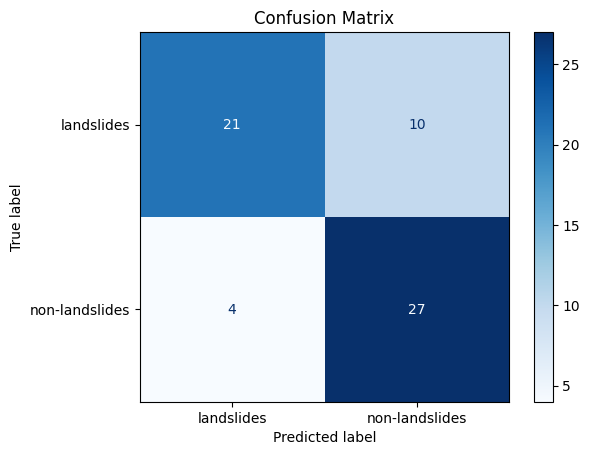

In [95]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [96]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 21  False Negatives (FN): 10
False Positives (FP): 4 True Negatives (TN): 27


Accuracy: 0.774
Precision: TP / (TP + FP) | Positive predictions are correct. 0.84
Recall: TP / (TP + FN) | Actual positive cases that are identified. 0.677
Specificity: TN / (TN + FP) | Actual negative cases that are identified. 0.871
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.75


### Identify Image File to Prediction|True Labels

In [97]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

Images with predicted and true labels:
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/22_02-Petropolis-5-1024x738.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/23_05-Kivu-1-768x768.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/North_Petropolis_Brazil_20220217_104400_ssc18_Flooding_rgb_3840-by-2160_50cm-1024x576.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.33.58 PM.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/Screen Shot 2024-12-06 at 12.35.39 PM.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/google_earth_unique_test_extracted/landslides/goog_image_two.jpg, Predicted: 1, True Label: 0
File: /home

2024-12-08 21:38:17.782848: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<hr style="border:25px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Fine Tuning - Opening Up Feature Layers
</span>** <br>

### **Number of Layers**

In [32]:
### Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num, learning_r=learn_rate_land)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

In [33]:
# Freeze all layers
for layer in landslide_model_ENB3.layers:
    layer.trainable = False

In [34]:
## Number of Layers to Open!!!
layer_open = 15
layer_open

15

In [35]:
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=.001)  ### set LR
    
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  

<hr style="border:3px solid #301b66">

### **Rebuild**

In [36]:
## Rebuild model with XX Layers open for Fine Tuning.
unfreeze_model(landslide_model_ENB3, layer_open)

In [37]:
### Review of the model structure:   Confirm that no layers are open after set.
# landslide_model_ENB3.summary(show_trainable=True)

## **Fit Model** 

In [38]:
## Build model while opening up XX number of layers, setup for Fitting. 
unfreeze_model(landslide_model_ENB3, layer_open)

epochs = 15  # @param {type: "slider", min:8, max:80}
ENB3_hist_fine = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)


Epoch 1/15


2024-12-08 23:18:23.123259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNet_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-08 23:18:25.553144: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
W0000 00:00:1733717905.851540  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717905.895582  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717905.896420  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717905.914267  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717905.917605  665428 gpu_timer.cc:114] Skipping the delay kernel, measureme

  2/190 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.6250 - loss: 0.5702

W0000 00:00:1733717906.725997  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.726827  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.727591  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.728307  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.729026  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.729744  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.730466  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.731253  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717906.732050  665428 gp

  4/190 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.6647 - loss: 0.5645

W0000 00:00:1733717907.018641  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.019472  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.020255  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.020971  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.021686  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.022405  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.023126  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.023923  665428 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717907.024717  665428 gp

136/190 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8627 - loss: 0.3133

W0000 00:00:1733717918.190631  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.191220  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.191760  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.192271  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.192778  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.193285  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.193796  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.194343  665422 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717918.194882  665422 gp

190/190 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.8743 - loss: 0.2913 - val_accuracy: 0.9439 - val_loss: 0.1311
Epoch 2/15
  1/190 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.9375 - loss: 0.1018

W0000 00:00:1733717927.262888  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.263456  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.263959  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.264449  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.264943  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.265440  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.265925  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.266442  665424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717927.266962  665424 gp

105/190 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9314 - loss: 0.1675

W0000 00:00:1733717936.098718  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.099303  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.099848  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.100356  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.100868  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.101381  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.101890  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.102444  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717936.102987  665427 gp

190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9293 - loss: 0.1721 - val_accuracy: 0.9588 - val_loss: 0.1184
Epoch 3/15
  1/190 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.9375 - loss: 0.1305

W0000 00:00:1733717946.103141  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.103714  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.104226  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.104714  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.105207  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.105702  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.106193  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.106714  665425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733717946.107234  665425 gp

190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9336 - loss: 0.1600 - val_accuracy: 0.9486 - val_loss: 0.1126
Epoch 4/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9487 - loss: 0.1317 - val_accuracy: 0.9598 - val_loss: 0.1018
Epoch 5/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9488 - loss: 0.1279 - val_accuracy: 0.9439 - val_loss: 0.1538
Epoch 6/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9449 - loss: 0.1385 - val_accuracy: 0.9710 - val_loss: 0.0798
Epoch 7/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9573 - loss: 0.1128 - val_accuracy: 0.9785 - val_loss: 0.0644
Epoch 8/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9465 - loss: 0.1354 - val_accuracy: 0.9598 - val_loss: 0.1101
Epoch 9/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9580 - loss: 0.1191 - val_accuracy: 0.9775 - val_loss: 0.0685
Epoch 10/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9560 - loss: 0.1208 - val_accura

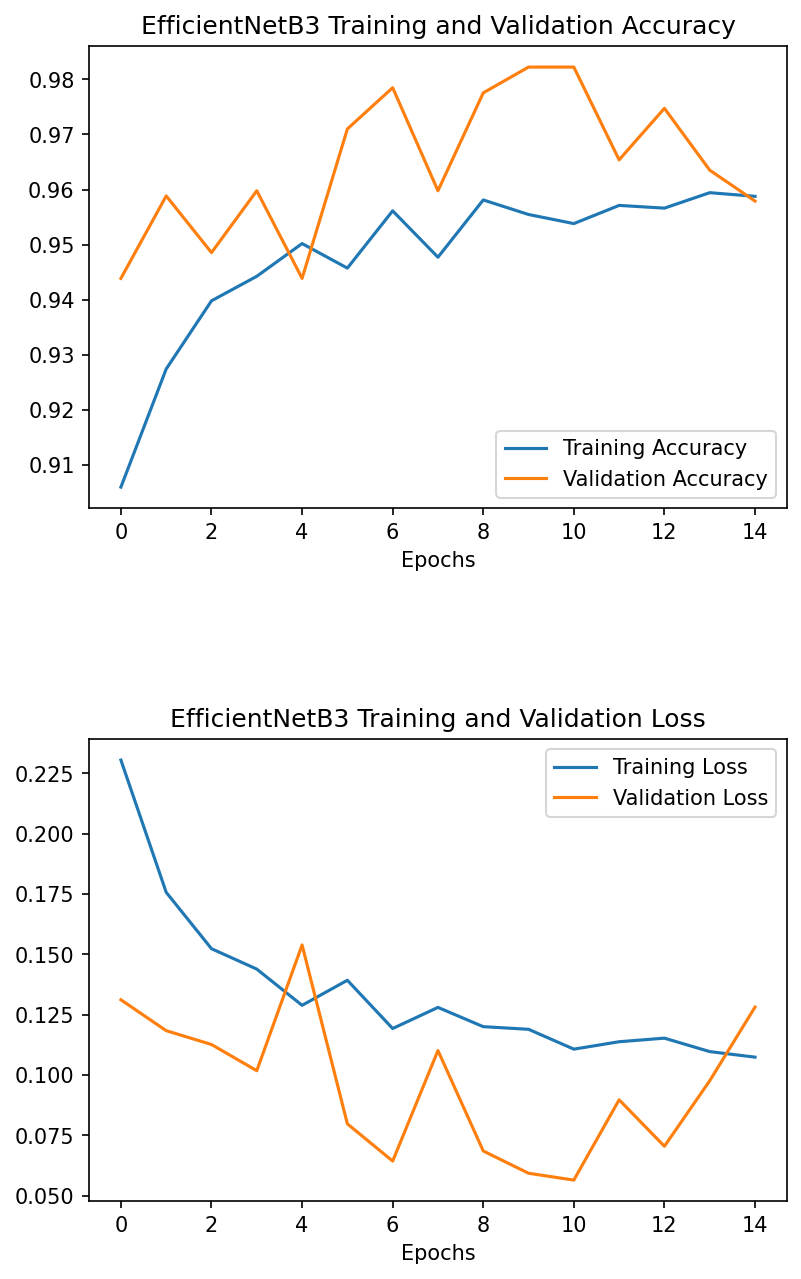

In [47]:
## Plot results
visualize_model_results(ENB3_hist_fine)

## **Testing**

In [40]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8296 - loss: 0.5881
test loss, test acc: [0.667840838432312, 0.8225806355476379]


W0000 00:00:1733718190.319437  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.320287  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.321039  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.321737  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.322431  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.323135  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.323837  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.324609  665427 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718190.325379  665427 gp

In [41]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


W0000 00:00:1733718194.037076  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.037895  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.038637  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.039332  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.040026  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.040727  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.041423  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.042198  665416 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733718194.042964  665416 gp

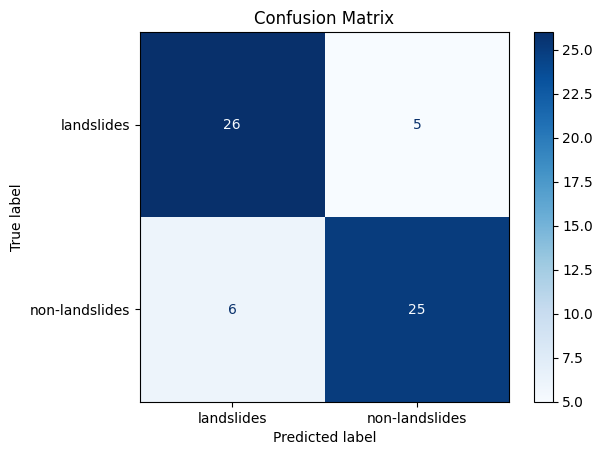

In [44]:
## Confusion Matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
# plt.figure(figsize=(8, 10), dpi=200)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [45]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 26  False Negatives (FN): 5
False Positives (FP): 6 True Negatives (TN): 25


Accuracy: 0.823
Precision: TP / (TP + FP) | Positive predictions are correct. 0.812
Recall: TP / (TP + FN) | Actual positive cases that are identified. 0.839
Specificity: TN / (TN + FP) | Actual negative cases that are identified. 0.806
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.825


### Identify Image File to Prediction|True Labels

In [ ]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Train Model on Full Population
</span>** <br>

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Saving Model for Future Use
</span>** <br>

In [ ]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
# model.save("my_model.keras")
landslide_model_ENB3.save("/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_40Lyr_hh.keras")